In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

# Application of Support Vector Machine (SVM)

## Preliminary part :

**1)** We show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

We try to solve the primal problem given by :

$ minimize_{\omega \in H, b \in \mathbb{R}} \frac{1}{2} ||\omega||^2$

Under the constraints : $ 1- y_i (\omega^T \phi(x_i) + b) \leq 0, \forall i = 1, ... , n $

For each training data, introduce a slack variable $\xi_i$ , Te primal problem then becomes :

$ minimize_{\omega \in H, b \in \mathbb{R}, \xi_i \in \mathbb{R}^+} \frac{1}{2} ||\omega||^2 + C. \sum_{i=1}^n \xi_i $

Under the constraints : $ y_i (\omega^T \phi(x_i) + b) \geq 1 - \xi_i, \forall i = 1, ... , n $

Which gives us , the following primal problem :

$ argmin_{\omega \in H, b \in \mathbb{R}, \xi_i \in \mathbb{R}^+} \frac{1}{2} ||\omega||^2 + C. \sum_{i=1}^n max(0,  1 - y_i (\omega^T \phi(x_i) + b) )= argmin_{\omega \in H, b \in \mathbb{R}, \xi_i \in \mathbb{R}^+} \frac{1}{2} ||\omega||^2 + C. \sum_{i=1}^n [1 - y_i (\omega^T \phi(x_i) + b)]_{+} $



So we get the following expression for the primal problem : 

$\fbox{$argmin_{\omega \in H, b \in \mathbb{R}, \xi_i \in \mathbb{R}^+} \frac{1}{2} ||\omega||^2 + C. \sum_{i=1}^n [1 - y_i (<\omega, \phi(x_i)> + b)]_{+} $}$

**2)** an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français)

In fact, after analyzing the previous question's response, we have established that the SVM problem can be expressed as a minimization problem of the prediction error $\fbox{$1 - y_i (\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0)$}$, which yields a positive outcome. Additionally, the Hinge loss, which is a convex function defined as $\fbox{$x \mapsto [1-x]_+ = \max(0,1-x)$}$, is used to minimize the classification error of SVMs. Therefore, the statement "an SVM minimizes the classification error using a convex upper bound" is accurate.

Regarding the Hinge loss, it provides superior accuracy and sparsity at the expense of reduced sensitivity to probabilities. However, it punishes misclassifications rather than aiding in probability estimation, making it appropriate for margin determinations. Moreover, binary classification loss varies depending on the situation, but when calculating error rates between 0 and 1 in machine learning, they are equivalent.

## Example of using the SVC class from scikit-learn

In [65]:
#  Data Generation

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 0.95
Testing score : 0.9


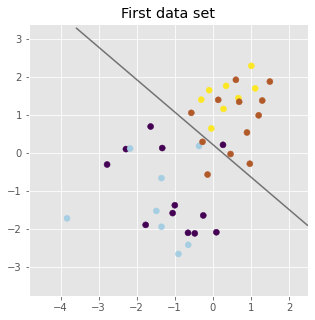

In [66]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**3)** We draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, we use the function ```make_blobs``` available in ```sklearn.datasets``` library. 75% of the data for training and 25% for the test data.


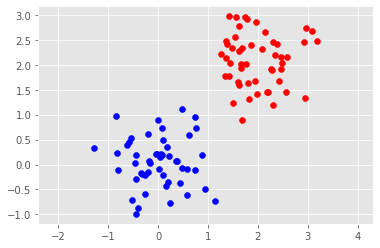

In [67]:
# Create two centers for the two distributions 
centers = np.array([[0, 0], [2, 2]])

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=100, centers=centers, random_state=0, n_features=2, cluster_std=0.5)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

In [68]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

**4)** Since the probability distributions are known, we numerically estimate the Bayes risk. 

We have the following approximate expression of the Bayes risk using monte carlo :

$\hat{R}_{Bayes} = \frac{1}{n} \sum_{i=1}^n \min(p(1|x), p(0|x))$

In [69]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use 
# to approximate the integral of the Bayes risk
n_mc = 1000 # Repeat this n_mc times - enough to approximate 
expectation = 0
for i in range(n_mc):

    # Random binary choice: will the point be generated from the first or second gaussian ?
    rand = np.random.binomial(1, 0.5)
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(centers[0], np.eye(2)*0.25)
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1], np.eye(2)*0.25)

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov=np.eye(2)*0.25)
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov=np.eye(2)*0.25)
    # Compute the risk from these and add it to the total
    a = p1/(p1+p2)
    b = p2/(p1+p2)
    risk = min(a, b)
    
    expectation += risk

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.001
Estimated Bayes accuracy: 0.999


**5)** We draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. We then vary the parameter C to see its impact on the number of support vectors. 


Train/Test scores: 1.0/1.0


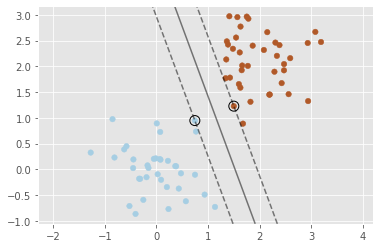

In [70]:
# Create a linear SVM and train it on the training data
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X_train, y_train)

print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**6)** We define the Gaussian classes such that the two distributions overlap. Then, we draw an i.i.d. sample from the joint probability distribution. We pply a 5-fold Cross-Validation to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.


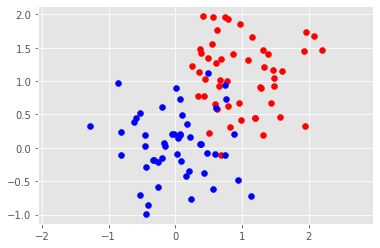

In [71]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5

# Create two centers for the two distributions 
centers = np.array([[0, 0], [1, 1]])

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=100, centers=centers, random_state=0, n_features=2, cluster_std=0.5)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


In [72]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X, y)

print("Best parameter: ", clf.best_params_)
print("Its accuracy score: ", clf.best_score_)



Best parameter:  {'C': 0.03162277660168379, 'kernel': 'linear'}
Its accuracy score:  0.93


Train/Test scores: 0.9466666666666667/0.88


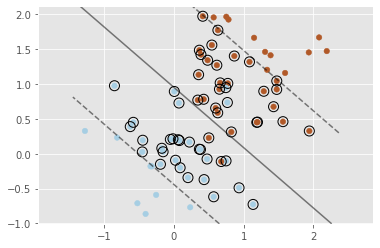

In [73]:
clf = svm.SVC(kernel='linear', C=clf.best_params_['C'])
clf.fit(X_train, y_train)

print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**7)** We observe that tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.


In [74]:
gammas = [0.1, 1, 10, 100]
# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores

for gamma in gammas:
    clf = svm.SVC(kernel='rbf', gamma=gamma, C=1)
    clf.fit(X_train, y_train)
    print(f'Train/Test scores with gamma={gamma}: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')
    


Train/Test scores with gamma=0.1: 0.9466666666666667/0.88
Train/Test scores with gamma=1: 0.9466666666666667/0.88
Train/Test scores with gamma=10: 0.96/0.88
Train/Test scores with gamma=100: 0.9866666666666667/0.64


We observe that the score on training set is very high which means the model has a good performance on the training data but not as  good on the test data. This is a sign of overfitting (especially for increasing values of gamma). 

## Non linear SVM

**8)** We define a new binary nonlinear classification problem :  one class as a Gaussian surrounded by the other chosen as a circle class, in such way that the separation problem is nonlinear.

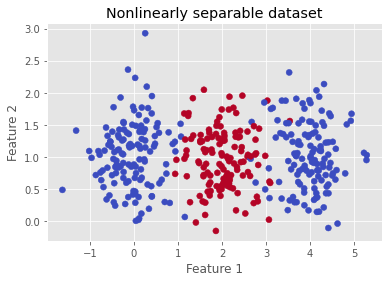

In [75]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0 

centers = [[0, 1], [2, 1], [4, 1]]
cluster_std = [0.5,0.5,0.5]
X, y = make_blobs(n_samples=400, centers=centers, cluster_std=cluster_std, random_state=42)
y[y == 2] = 0  # Change the label from 2 to 0

# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Nonlinearly separable dataset')
plt.show()

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


**9)** We use an SVM with a linear kernel then a Gaussian (with well-adapted parameters) then we plot the decision boundaries of these algorithms on separate graphs.


### i : SVM With linear kernel

In [76]:
# Use the code of question 6 again

# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 3))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X, y)

print("Best parameter: ", clf.best_params_)
print("Its accuracy score: ", clf.best_score_)



Best parameter:  {'C': 0.001, 'kernel': 'linear'}
Its accuracy score:  0.6675000000000001


Train/Test scores: 0.6766666666666666/0.64


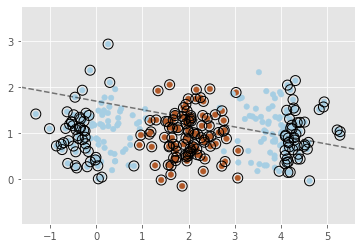

In [77]:
clf = svm.SVC(kernel='linear', C=clf.best_params_['C'])
clf.fit(X_train, y_train)

print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

### ii : SVM With Gaussian kernel

In [78]:
# Use the code of question 6 again

# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['rbf'], 'C': list(np.logspace(-3, 3, 3))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X, y)

print("Best parameter: ", clf.best_params_)
print("Its accuracy score: ", clf.best_score_)

Best parameter:  {'C': 1.0, 'kernel': 'rbf'}
Its accuracy score:  0.96


Train/Test scores: 0.97/0.95


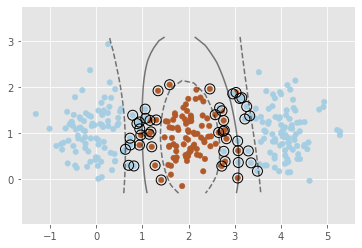

In [79]:
clf = svm.SVC(kernel='rbf', C=clf.best_params_['C'])
clf.fit(X_train, y_train)

print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

## Learning curve

**10)** We draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, we calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, we repeat the experiment a large number of times to average the performance. 
Then, we plot the train and test error based on the size of the train set subset. And we estimate and display the accuracy of the Bayes predictor on the same graph.


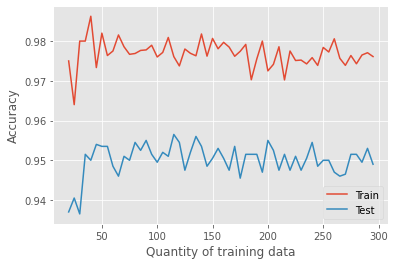

In [80]:
# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times 
n_m = 20  

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        svm = SVC(kernel='rbf', C=1)
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]
        
        # Fit the classifier and compute the scores on training and test data
        svm.fit(X_train_reduced, y_train_reduced)
    # Add the average of the scores to the lists
        score_train += svm.score(X_train_reduced, y_train_reduced)
        score_test += svm.score(X_test, y_test)
    scores_train.append(score_train/n_m)
    scores_test.append(score_test/n_m)
# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [81]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4). 


from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use 
# to approximate the integral of the Bayes risk
n_mc = 1000 # Repeat this n_mc times - enough to approximate 
expectation = 0
for i in range(n_mc):

    # Random binary choice: will the point be generated from the first or second or third gaussian
    rand = np.random.choice(3)
    x = np.random.multivariate_normal(centers[rand], np.eye(2)*0.25)

    # You have to compute the conditional posterior probability of x given the 3 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov=np.eye(2)*0.25)
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov=np.eye(2)*0.25)
    p3 = multivariate_normal.pdf(x, mean=centers[2], cov=np.eye(2)*0.25)
    # Compute the risk from these and add it to the total
    a = p1/(p1+p2+p3)
    b = p2/(p1+p2+p3)
    c = p3/(p1+p2+p3)

    risk = min(a,b,c)
    
    expectation += risk

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')


Estimated Bayes risk: 0.0
Estimated Bayes accuracy: 1.0


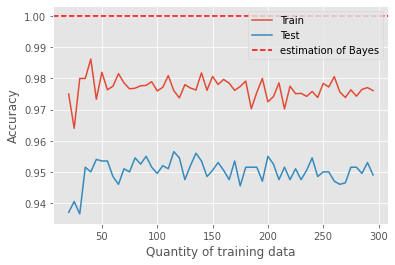

In [82]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph

plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.axhline(y=1-expectation, color='r', linestyle='--', label='estimation of Bayes')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



<div class='alert alert-block alert-warning'>
            Answer:</div>

## Error versus complexity

**11)** We add noise to the dataset by randomly modifying the labels of some training data. Then, we draw the complexity curves of the algorithm : with set train and test set,we draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity).

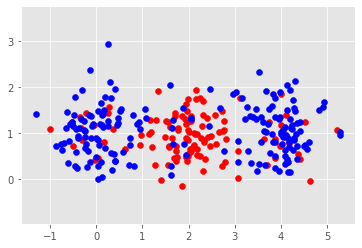

In [83]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

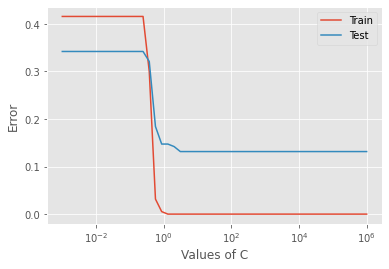

In [87]:
# Vary the appropriate parameter and plot the training/testing results
C_values = np.logspace(-3, 6, 50)

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for c in C_values:

    svm = SVC(kernel='rbf', C=c)
    svm.fit(X_train, y_train)

    scores_train.append(1- svm.score(X_train, y_train))
    scores_test.append(1-svm.score(X_test, y_test))
# Plot the results
plt.plot(C_values, scores_train, label='Train')
plt.plot(C_values, scores_test, label='Test')
plt.xscale('log')
plt.xlabel('Values of C')
plt.ylabel('Error')

plt.legend()
plt.show()

We observe that for values of C greater than 10⁰, the model is overfitting the training data. This is because the model is too complex and is not able to generalize well on the test data. For values smaller than 10⁰, the model has a normal performance since the error decreases.